In [279]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.manifold import TSNE
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch import optim
from geomloss import SamplesLoss
from torch.autograd import Function
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.nn.functional import normalize
#from torchmetrics.classification import BinaryAccuracy
from torchmetrics.classification import BinaryF1Score
torch.manual_seed(0)

In [280]:
class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.len = self.X.shape[0]
       
    def __getitem__(self, index):
        return self.X[index], self.y[index]
   
    def __len__(self):
        return self.len

In [281]:
def get_data(data_type,file_num):

    if(data_type=='train'):
        data=pd.read_csv(f"Dataset/IHDP_a/ihdp_npci_train_{file_num}.csv")
    else:
        data = pd.read_csv(f"Dataset/IHDP_a/ihdp_npci_test_{file_num}.csv")

    x_data=pd.concat([data.iloc[:,0], data.iloc[:, 1:30]], axis = 1)
    #x_data=data.iloc[:, 5:30]
    y_data=data.iloc[:, 1]
    return x_data,y_data

In [282]:
def get_dataloader(x_data,y_data,batch_size):

    x_train_sr=x_data[x_data['treatment']==0]
    y_train_sr=y_data[x_data['treatment']==0]
    x_train_tr=x_data[x_data['treatment']==1]
    y_train_tr=y_data[x_data['treatment']==1]


    train_data_sr = Data(np.array(x_train_sr), np.array(y_train_sr))
    train_dataloader_sr = DataLoader(dataset=train_data_sr, batch_size=batch_size)

    train_data_tr = Data(np.array(x_train_tr), np.array(y_train_tr))
    train_dataloader_tr = DataLoader(dataset=train_data_tr, batch_size=batch_size)


    return train_dataloader_sr, train_dataloader_tr

In [283]:
def regression_loss(concat_true, concat_pred):
    #computes a standard MSE loss for TARNet
    y_true = concat_true[:, 0] #get individual vectors
    t_true = concat_true[:, 1]

    y0_pred = concat_pred[:, 0]
    y1_pred = concat_pred[:, 1]

    #Each head outputs a prediction for both potential outcomes
    #We use t_true as a switch to only calculate the factual loss
    loss0 = torch.sum((1. - t_true) * torch.square(y_true - y0_pred))
    loss1 = torch.sum(t_true * torch.square(y_true - y1_pred))
    #note Shi uses tf.reduce_sum for her losses instead of tf.reduce_mean.
    #They should be equivalent but it's possible that having larger gradients accelerates convergence.
    #You can always try changing it!
    return loss0 + loss1

In [284]:
def loss_cal(X_data,y_data,net,alpha):
    
    x_train_sr=X_data[X_data['treatment']==0]
    y_train_sr=y_data[X_data['treatment']==0]
    x_train_tr=X_data[X_data['treatment']==1]
    y_train_tr=y_data[X_data['treatment']==1]
    xs_t=x_train_sr.iloc[:,0].to_numpy()
    xt_t=x_train_tr.iloc[:,0].to_numpy()
    
    xs=x_train_sr.iloc[:,5:30].to_numpy()
    xt=x_train_tr.iloc[:,5:30].to_numpy()
    xs_t=torch.from_numpy(xs_t.astype(np.float32))
    xt_t=torch.from_numpy(xt_t.astype(np.float32))
    y_train_sr=y_train_sr.to_numpy()
    y_train_tr=y_train_tr.to_numpy()
    xs=torch.from_numpy(xs.astype(np.float32))
    xt=torch.from_numpy(xt.astype(np.float32))
    
    y_train_sr=torch.from_numpy(y_train_sr.astype(np.float32))
    y_train_tr=torch.from_numpy(y_train_tr.astype(np.float32))
    
    
    input_data=torch.cat((xs,xt),0)
    true_y=torch.unsqueeze(torch.cat((y_train_sr,y_train_tr),0), dim=1)
    true_t=torch.unsqueeze(torch.cat((xs_t,xt_t),0), dim=1)
    
    
    concat_true=torch.cat((true_y,true_t),1)
    concat_pred,d_out=net(input_data,alpha)
    loss=regression_loss(concat_true, concat_pred)
    
    return loss.item()

In [285]:
def pehe_loss_2(y1_pred,y0_pred,mu_1,mu_0):
    a=((mu_1-mu_0)-(y1_pred-y0_pred))
    er1=torch.square(a)
    #pehe=torch.mean(er1)
    pehe=torch.sqrt(torch.mean(er1))
    return pehe

In [286]:
# PEHE evaluation
def cal_pehe(i,alpha):
    data,y=get_data('test',i)

    data=data.to_numpy()
    data=torch.from_numpy(data.astype(np.float32))



    concat_pred,phi=net(data[:,5:30],alpha)
    #dont forget to rescale the outcome before estimation!
    #y0_pred = data['y_scaler'].inverse_transform(concat_pred[:, 0].reshape(-1, 1))
    #y1_pred = data['y_scaler'].inverse_transform(concat_pred[:, 1].reshape(-1, 1))
    cate_pred=concat_pred[:,1]-concat_pred[:,0]
    cate_true=data[:,4]-data[:,3] #Hill's noiseless true values


    cate_err=torch.mean( torch.square( ( (cate_true) - (cate_pred) ) ) )

    return torch.sqrt(cate_err).item()

In [287]:
class TarNet(nn.Module):
    def __init__(self,
                 input_dim,
                 regularization=.01):
        super(TarNet, self).__init__()
        self.encoder1 = nn.Linear(input_dim, 32)
        self.encoder2 = nn.Linear(32, 16)
        self.encoder3 = nn.Linear(200, 200)
        
        self.dis1_d = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Dropout(p=regularization)
        )
        self.dis2_d = nn.Sequential(
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(p=regularization)
        )
        
        self.dis3_d = nn.Sequential(
            nn.Linear(16, 2),
            nn.ReLU(),
            nn.Dropout(p=regularization)
        )
       
        

        self.regressor1_y0 = nn.Sequential(
            nn.Linear(16, 16),
            nn.ELU(),
            nn.Dropout(p=regularization),
        )
        self.regressor2_y0 = nn.Sequential(
            nn.Linear(16, 1),
            nn.ELU(),
            nn.Dropout(p=regularization),
        )
        

        self.regressor1_y1 = nn.Sequential(
            nn.Linear(16, 16),
            nn.ELU(),
            nn.Dropout(p=regularization),
        )
        self.regressor2_y1 = nn.Sequential(
            nn.Linear(16, 1),
            nn.ELU(),
            nn.Dropout(p=regularization),
        )



    def forward(self, inputs,alpha):
        x = nn.functional.elu(self.encoder1(inputs))
        phi= nn.functional.elu(self.encoder2(x))
        #phi = nn.functional.elu(self.encoder3(x))
        
 

        out_y0 = self.regressor1_y0(phi)
        y0 = self.regressor2_y0(out_y0)
        #y0 = self.regressorO_y0(out_y0)

        out_y1 = self.regressor1_y1(phi)
        y1= self.regressor2_y1(out_y1)
        #y1 = self.regressorO_y1(out_y1)
        
        rev = ReverseLayerF.apply(phi, alpha)
        
        out_d1 = self.dis1_d(rev)
        out_d2 = self.dis2_d(out_d1)
        d_out = self.dis3_d(out_d2)

        concat = torch.cat((y0, y1), 1)
        return concat,d_out

class ReverseLayerF(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None
    
class GRL(Function):
    @staticmethod
    def forward(ctx, tensor, constant):
        ctx.constant = constant
        return tensor * constant
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.constant, None


class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.linear1 = nn.Linear(200, 100)
    self.linear2 = nn.Linear(100, 100)
    self.linear3 = nn.Linear(100, 2)
    #self.linear4 = nn.Linear(50, 2)
    
    self.act1 = nn.ReLU()
    self.dropout=nn.Dropout(p=.001)
    
   
    
  def forward(self, x, alpha):
    x = ReverseLayerF.apply(x, alpha)
    #x = torch.sigmoid(self.linear1(x))
    x = self.linear1(x)
    x = self.act1(x)
    x= self.dropout(x)
    x = self.linear2(x)
    x = self.act1(x)
    x= self.dropout(x)
    x = self.linear3(x)
    return x

In [288]:
epochs=300
batch_size=32
criterion = nn.CrossEntropyLoss()

In [289]:
train_loss=[]
val_loss=[]
d_loss=[]
pehe_error=[]
num_files=2
for nf in range(1,num_files):
    x_data,y_data=get_data('train',nf)
    X_train, X_val,y_train, y_val = train_test_split(x_data,y_data ,
                                       random_state=42, 
                                       test_size=0.20)
    net=TarNet(25,.01)
    domain_descr = Discriminator()
    opt_net = torch.optim.Adam(net.parameters(), lr=1e-4)
    #opt_dis=torch.optim.Adam(domain_descr.parameters(), lr=1e-5)
  

    for ep in range(1,epochs+1 ):
        
        lamda_max=10
        e0=20
        train_dataloader_sr, train_dataloader_tr=get_dataloader(X_train,y_train,batch_size)
        
        #len_dataloader = min(len(train_dataloader_sr), len(train_dataloader_tr))
        #total_steps = epochs * len(train_dataloader_sr)
        #i = 0
        lambda_val=(lamda_max)*((ep-e0)/(epochs-e0))
        alpha=max(0,lambda_val)
        dis_loss=0
 
        for batch_idx, (train_source_data, train_target_data) in enumerate(zip(train_dataloader_sr, train_dataloader_tr)):
            
            xs,ys=train_source_data
            xt,yt=train_target_data
            
            xs_train=xs[:,5:30]
            xt_train=xt[:,5:30]
            
            train_x=torch.cat((xs_train,xt_train),0)
            train_y=torch.unsqueeze(torch.cat((ys,yt),0), dim=1)
            true_t=torch.unsqueeze(torch.cat((xs[:,0],xt[:,0]),0), dim=1)
            concat_true=torch.cat((train_y,true_t),1)
            concat_pred,d_out=net(train_x,alpha)
            
            #s_zeros_t=torch.zeros(xs_train.shape[0],1)
            #t_ones_t=torch.ones(xt_train.shape[0],1)

            #labels=torch.cat((s_zeros_t,t_ones_t),0)
            
            labels_discr=torch.cat((xs[:,0].type(torch.LongTensor),xt[:,0].type(torch.LongTensor)),0)
            #outputs_discr = domain_descr(phi,alpha)
            
            opt_net.zero_grad()
            #opt_dis.zero_grad()
            
            #source_mse=criterion_reg(y0,ys)
            #target_mse=criterion_reg(y1,yt)
            domain_loss=criterion(d_out, labels_discr)
            reg_loss=regression_loss(concat_true,concat_pred)
            #combined loss
            combined_loss=domain_loss+reg_loss
            #print('Training loss: ',combined_loss.item())
            # backward propagation
            combined_loss.backward()
            dis_loss= dis_loss+domain_loss.item()
            # optimize
            opt_net.step()
            #opt_dis.step()
        train_loss.append(loss_cal(X_train,y_train,net,alpha))
        val_loss.append(loss_cal(X_val,y_val,net,alpha))
        d_loss.append(dis_loss)
    pehe_error.append(cal_pehe(nf,alpha))
        


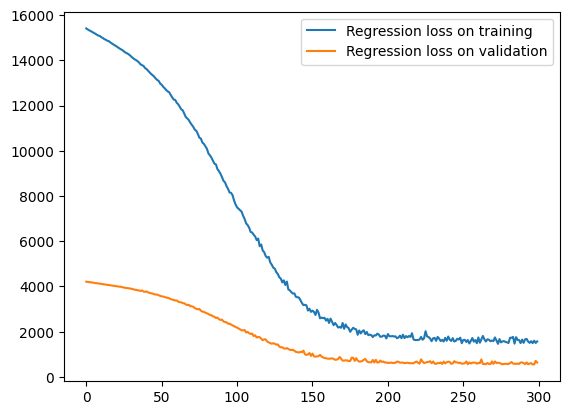

In [290]:
plt.plot(train_loss, label='Regression loss on training')
plt.plot(val_loss, label='Regression loss on validation')
plt.legend()
plt.show()

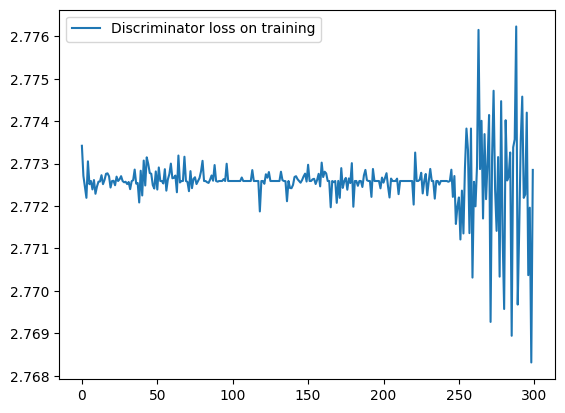

In [291]:
plt.plot(d_loss, label='Discriminator loss on training')
plt.legend()
plt.show()

In [292]:
print(np.mean(pehe_error))

1.930543065071106


In [293]:
print(np.max(pehe_error))

1.930543065071106


In [1318]:
'''
class TarNet(nn.Module):
    def __init__(self,
                 input_dim,
                 regularization=.01):
        super(TarNet, self).__init__()
        self.encoder1 = nn.Linear(input_dim, 200)
        self.encoder2 = nn.Linear(200, 200)
        self.encoder3 = nn.Linear(200, 200)
        
        self.dis1_d = nn.Sequential(
            nn.Linear(200, 2),
            nn.ReLU(),
            nn.Dropout(p=regularization)
        )
        self.dis2_d = nn.Sequential(
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Dropout(p=regularization),
        )
        self.dis3_d = nn.Sequential(
            nn.Linear(100, 2)
        )
        

        self.regressor1_y0 = nn.Sequential(
            nn.Linear(200, 100),
            nn.ELU(),
            nn.Dropout(p=regularization),
        )
        self.regressor2_y0 = nn.Sequential(
            nn.Linear(100, 100),
            nn.ELU(),
            nn.Dropout(p=regularization),
        )
        self.regressorO_y0 = nn.Linear(100, 1)

        self.regressor1_y1 = nn.Sequential(
            nn.Linear(200, 100),
            nn.ELU(),
            nn.Dropout(p=regularization),
        )
        self.regressor2_y1 = nn.Sequential(
            nn.Linear(100, 100),
            nn.ELU(),
            nn.Dropout(p=regularization),
        )
        self.regressorO_y1 = nn.Linear(100, 1)


    def forward(self, inputs,alpha):
        x = nn.functional.elu(self.encoder1(inputs))
        x = nn.functional.elu(self.encoder2(x))
        phi = nn.functional.elu(self.encoder3(x))
        
 

        out_y0 = self.regressor1_y0(phi)
        out_y0 = self.regressor2_y0(out_y0)
        y0 = self.regressorO_y0(out_y0)

        out_y1 = self.regressor1_y1(phi)
        out_y1 = self.regressor2_y1(out_y1)
        y1 = self.regressorO_y1(out_y1)
        
        rev = ReverseLayerF.apply(phi, alpha)
        
        out_d1 = self.dis1_d(rev)
        #out_d2 = self.dis2_d(out_d1)
        #d_out = self.dis3_d(out_d2)

        concat = torch.cat((y0, y1), 1)
        return concat,out_d1

class ReverseLayerF(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None
    
class GRL(Function):
    @staticmethod
    def forward(ctx, tensor, constant):
        ctx.constant = constant
        return tensor * constant
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.constant, None


class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.linear1 = nn.Linear(200, 100)
    self.linear2 = nn.Linear(100, 100)
    self.linear3 = nn.Linear(100, 2)
    #self.linear4 = nn.Linear(50, 2)
    
    self.act1 = nn.ReLU()
    self.dropout=nn.Dropout(p=.001)
    
   
    
  def forward(self, x, alpha):
    x = ReverseLayerF.apply(x, alpha)
    #x = torch.sigmoid(self.linear1(x))
    x = self.linear1(x)
    x = self.act1(x)
    x= self.dropout(x)
    x = self.linear2(x)
    x = self.act1(x)
    x= self.dropout(x)
    x = self.linear3(x)
    return x
'''
